# Install

In [6]:
import torch
   
device = torch.device("cpu")


In [7]:
!pip install transformers

     |████████████████████████████████| 1.8MB 9.0MB/s 
     |████████████████████████████████| 890kB 44.9MB/s 
     |████████████████████████████████| 3.2MB 37.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=7630bcc870751e2943be07a609c453eb791b34b65c3ecc91d7de66a768b03df6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [41]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=f5fcc2e8dfa156c0f1159ec8830cb2659324ec42b01c24f697e33d5020715a1c
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


# Load dataset

In [42]:
# import wget
# import os

# # Download the dataset if we haven't already
# url = 'https://github.com/nicolamarnat/Projet_DL/tree/master/dataset/dataset.zip'

# if not os.path.exists('./dataset.zip'):
#     print('Downloading dataset...')
#     wget.download(url, './dataset.zip')
    
# # Unzip the dataset (if we haven't already)
# if not os.path.exists('./dataset/'):
#     print('Extracting the dataset files...')
#     !unzip dataset.zip

In [8]:
import pandas as pd

df = pd.read_csv("/content/relation_dataset_label.csv", delimiter=';', header=None, names=['relation', 'label'])

df.head()

,relation,label
0,"ville Paris comptait 2,187 millions habitants ...",1
1,Paris joue rôle plan histoire Europe monde,0
2,Paris symbolise culture française,1
3,région parisienne accueille institutions inter...,0
4,région parisienne une riches régions Europe,1


In [9]:
relations = df.relation.values
labels = df.label.values

# Bert tokenizer

In [10]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [12]:
# Print the original sentence.
print(' Original: ', relations[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(relations[0]))

# Print the encoded sentence, ie., mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(relations[0])))

 Original:  ville Paris comptait 2,187 millions habitants 1er janvier 2020
Tokenized:  ['ville', 'Paris', 'comptait', '2', ',', '187', 'millions', 'habitants', '1er', 'janvier', '2020']
Token IDs:  [11743, 10728, 28865, 123, 117, 23228, 18123, 12198, 99276, 13529, 23607]


In [13]:
# Tokenize all of the relations and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for rel in relations:
    encoded_dict = tokenizer.encode_plus(rel, add_special_tokens = True, max_length = 64, truncation=True,
                        pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', relations[0])
print('Token IDs:', input_ids[0])

Original:  ville Paris comptait 2,187 millions habitants 1er janvier 2020
Token IDs: tensor([  101, 11743, 10728, 28865,   123,   117, 23228, 18123, 12198, 99276,
        13529, 23607,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Train and validation split

In [16]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('Training samples {}'.format(train_size))
print('Validation samples {}'.format(val_size))

Training samples 167
Validation samples 19


# Training

In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 40

# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset),
            batch_size = batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

model = BertForSequenceClassification.from_pretrained( "bert-base-multilingual-cased", num_labels = 2,
    output_attentions = False, output_hidden_states = False)

# Send model to GPU
model.cpu()

In [53]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [54]:
import numpy as np
import time
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [69]:
import random
import numpy as np

# Set the seed for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# To store training stats
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack ther training batch and send them to GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear Grads
        model.zero_grad()        

        # Perform a forward pass 
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss = total_train_loss + outputs.loss.item()

        # Perform a backward pass
        outputs.loss.backward()

        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # Validation

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # No need to accumulate the grads
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += outputs.loss.item()

        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final stats
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)

    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Save stats
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.70
  Training epoch took: 0:01:53

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.65
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.62
  Training epoch took: 0:01:45

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.44
  Validation took: 0:00:04

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.65
  Training epoch took: 0:01:45

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.45
  Validation took: 0:00:04

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.64
  Training epoch took: 0:01:45

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.46
  Validation took: 0:00:04
Training complete!
Total training took 0:07:23 (h:mm:ss)


In [72]:
import pandas as pd

# Use two decimal places.
pd.set_option('precision', 2)
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.70,0.65,0.84,0:01:53,0:00:04
2,0.62,0.44,0.84,0:01:45,0:00:04
3,0.65,0.45,0.84,0:01:45,0:00:04
4,0.64,0.46,0.84,0:01:45,0:00:04


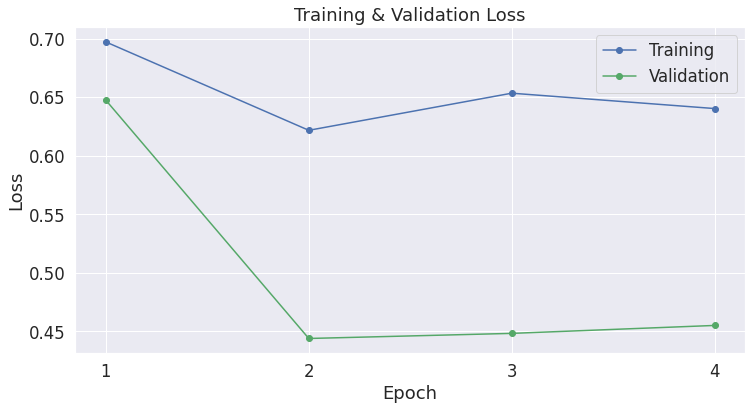

In [73]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Lower batch size

In [19]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 10

# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset),
            batch_size = batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

model = BertForSequenceClassification.from_pretrained( "bert-base-multilingual-cased", num_labels = 2,
    output_attentions = False, output_hidden_states = False)

# Send model to GPU
model.cpu()

In [21]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [22]:
import numpy as np
import time
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [23]:
import random
import numpy as np

# Set the seed for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# To store training stats
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack ther training batch and send them to GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear Grads
        model.zero_grad()        

        # Perform a forward pass 
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss = total_train_loss + outputs.loss.item()

        # Perform a backward pass
        outputs.loss.backward()

        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # Validation

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # No need to accumulate the grads
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += outputs.loss.item()

        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final stats
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)

    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Save stats
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.65
  Training epoch took: 0:02:14

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.57
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.63
  Training epoch took: 0:02:18

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.57
  Validation took: 0:00:04

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.60
  Training epoch took: 0:02:13

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.56
  Validation took: 0:00:04

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.60
  Training epoch took: 0:02:13

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.56
  Validation took: 0:00:04
Training complete!
Total training took 0:09:14 (h:mm:ss)


In [24]:
import pandas as pd

# Use two decimal places.
pd.set_option('precision', 2)
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.65,0.57,0.74,0:02:14,0:00:04
2,0.63,0.57,0.74,0:02:18,0:00:04
3,0.60,0.56,0.74,0:02:13,0:00:04
4,0.60,0.56,0.74,0:02:13,0:00:04


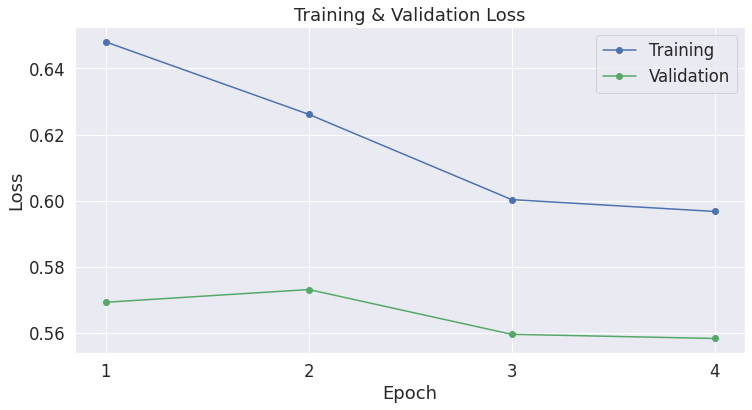

In [25]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Test model

In [32]:
import pandas as pd

df = pd.read_csv("/content/test_dataset_label.csv", delimiter=';', header=None, names=['relation', 'label'])

df.head()

,relation,label
0,ville successivement centre monarchie romaine,1
1,-1455 perpétuent tradition architecture romaine,0
2,Rome fait principales destinations touristique...,0
3,Ville Éternelle une monde,1
4,siège papauté pèlerinage Rome font lieu éminent,1


In [33]:
sentences = df.relation.values
labels = df.label.values

In [34]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

input_ids = []
attention_masks = []

# We use the same max_lenght than before
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(sent, add_special_tokens = True, max_length = 64, truncation=True,
                        pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  ville successivement centre monarchie romaine
Token IDs: tensor([  101, 11743, 44008, 12672, 83130, 38183,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [35]:
# Create the Datasets & DataLoader.

test_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 10
test_dataloader = DataLoader(test_dataset, sampler = RandomSampler(test_dataset),
            batch_size = batch_size)

In [40]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables, append the labels and prediction using these two lists
predictions , true_labels = [], []

for batch in test_dataloader:

  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
  
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = outputs.logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [42]:
print(true_labels)

[array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1]), array([1, 1, 0, 0, 1, 1, 0, 1, 0, 1]), array([1, 1, 1, 1, 1, 0, 1, 1, 0, 0]), array([1, 0, 0, 1, 1, 1, 1, 0, 0, 0]), array([1, 0, 0, 1, 1, 0, 1, 0, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0]), array([1, 1, 1, 1, 0, 0, 1, 0, 0, 0])]


In [43]:
print(predictions)

[array([[-0.41316172,  0.6019027 ],
       [-0.35804683,  0.64368725],
       [-0.39028102,  0.6347133 ],
       [-0.51042384,  0.6324158 ],
       [-0.4243289 ,  0.56064117],
       [-0.45209223,  0.59894776],
       [-0.36274227,  0.58691514],
       [-0.41676068,  0.6738789 ],
       [-0.38808236,  0.6430161 ],
       [-0.369007  ,  0.56511617]], dtype=float32), array([[-0.36704007,  0.59215254],
       [-0.39133686,  0.6135671 ],
       [-0.42584   ,  0.5940279 ],
       [-0.45341277,  0.57835823],
       [-0.4160325 ,  0.6148381 ],
       [-0.37360162,  0.61913973],
       [-0.43466896,  0.59173226],
       [-0.38966626,  0.6026983 ],
       [-0.38923874,  0.57773066],
       [-0.4147506 ,  0.5969982 ]], dtype=float32), array([[-0.41842818,  0.58392996],
       [-0.36173993,  0.58004725],
       [-0.3784059 ,  0.5624842 ],
       [-0.48038006,  0.644591  ],
       [-0.39833754,  0.57179016],
       [-0.39600798,  0.60779095],
       [-0.37489954,  0.59643763],
       [-0.34357232,

In [37]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 42 of 70 (60.00%)


In [41]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
